In [1]:
%matplotlib widget

Monte Carlo is a learning method for estimating value functions and discovering optimal policy. Unlike dynamic programming seen previously, this method does not require complete knowledge of the environment - _environment dynamics given by four-argument parameter $p$_. Monte Carlo method requires _experience_ - sample sequence of state, action, rewards by interacting with environment.<br>
Monte Carlo method averages over the returns seen in a particular state. To ensure that well-defined returns are available, here we define Monte Carlo methods for episodic tasks.<br>
- Experiance is divided into _episodes_ and episodes always end up in a terminal state no matter what actions are chosen

Monte Carlo method can be seen as multiple _Bandits_, each for a particular state. Since return after taking some action in one state depends of the actions taken in later states in the same episode. Because all the action selections are undergoing learning, the problem becomes nonstationary from the point of view of the earlier state.

## Monte Carlo prediction
Recall that value of each state is the expected return - cumulative future discounted reward starting from that state. So to find the expected return from experience we can average over the returns seen in state $s$.<br>
Particularly, we need to estimate $v_\pi(s)$, that is value of state $s$ under policy $\pi$ given a set of episodes obtained by following policy $\pi$. Each occurance to state $s$ is called _visit_ to $s$. In an episode state $s$ might be visited multiple times; so we are calling the first time we visit $s$, _first visit_. __first-visit MC__ estimates $v_\pi(s)$ following first visit to $s$. Whereas the __every-visit MC__ method averages the returns following all visits to $s$.

### Blackjack Example

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
EXCEED = 21
FACE_CARD = 10
DISCOUNT = 1
CARDS = [x for x in range(1, 11)] * 4 + [FACE_CARD for _ in range(4 * 3)]

In [4]:
# Each state shows total of the player's cards from [12, 21] and the dealers showing cards (Ace-10) and whether or not he own a usable ace
state_value = np.zeros((22, 11, 2), dtype=np.int32)
state = [0, 0, 0] # player's total, dealers first card, usable ace respectively

# Example states: policy is that player sticks if player's sum is 20 or 21, otherwise hits
policy = np.zeros_like(state_value, dtype=np.int32)
policy[[20, 21], :, :] = 1

In [5]:
def initial_dealers_cards(state):
    # initial dealers
    dealer_usable = 0
    card_chosen = np.random.choice(CARDS)
    if card_chosen == 1: 
        state[1] = 11
        dealer_usable += 1
    else: state[1] = card_chosen
    # Face-up card is what player is going to act with (using his policy)
    face_up_card = card_chosen
    return face_up_card, dealer_usable

def inital_players_cards(state):
    # initial players
    # Player's first card
    card_chosen = np.random.choice(CARDS)
    if card_chosen == 1:
        state[0] += 11
        state[2] += 1
    else: state[0] += card_chosen

    # Player's second card
    card_chosen = np.random.choice(CARDS)
    if card_chosen == 1:
        state[0] += 11
        state[2] += 1
    else: state[0] += card_chosen

    # Using usable-ace
    if state[0] > EXCEED:
        state[0] -= 10
        state[2] -= 1
    

In [6]:
def generate_episode(policy):
    state = [0, 0, 0]

    face_up_card, dealer_usable = initial_dealers_cards(state)
    inital_players_cards(state)
    
    states = []
    actions = []
    rewards = []

    states.append([state[0], state[1], 0 if state[2] == 0 else 1])

    while True:
        action = policy[state[0], face_up_card, 0 if state[2] == 0 else 1]
        if action == 0:
            state = hit(state)
            if state[0] > EXCEED: reward = -1
            else: reward = 0
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            if reward == -1: return states, actions, rewards
            else: continue
            
        else:
            state = stick(state, dealer_usable)
            if state[1] > EXCEED:
                reward = 1
            elif state[1] == state[0]:
                reward = 0
            elif state[1] < state[0]:
                reward = 1
            else:
                reward = -1
                
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            return states, actions, rewards
        

def hit(state):
    player, dealer, usable_ace = state
    card_chosen = np.random.choice(CARDS)
    if card_chosen == 1: 
        player += 11
        usable_ace += 1
    else: player += card_chosen

    if player > EXCEED and usable_ace >= 1:
        player -= 10
        usable_ace -= 1
    
    return [player, dealer, usable_ace]

def stick(state, dealer_usable):
    player, dealer, usable_ace = state
    while dealer < 17:
        card_chosen = np.random.choice(CARDS)
        if card_chosen == 1: 
            dealer += 11
            dealer_usable += 1
        else: dealer += card_chosen

        if dealer > EXCEED and dealer_usable >= 1:
            dealer -= 10
            dealer_usable -= 1
    return [player, dealer, usable_ace]
            

### First-visit MC prediction for estimating $V \approx v_\pi$

In [7]:
def first_visit_mc(policy, episodes=10000, verbose=True):
    value = np.zeros_like(policy, dtype='float32')
    returns_sum = {}
    returns_count = {}
    
    for episode in range(episodes):
        if verbose:
            print(f'\rEpisode {episode + 1:>7} out of {episodes:>7}', end='')
            
        states, actions, rewards = generate_episode(policy)
        initial_dealer = states[0][1] 
        initial_dealer = initial_dealer if initial_dealer != 11 else 1
        
        G = 0
        T = len(states)
        visited = set()
        
        for t in reversed(range(0, T - 1)):
            G = DISCOUNT * G + rewards[t]

            player, _, usable = states[t]
            current_state = (player, initial_dealer, usable)
            if current_state not in visited:
                visited.add(current_state)
                if current_state not in returns_sum:
                    returns_sum[current_state] = 0
                    returns_count[current_state] = 0
                returns_sum[current_state] += G
                returns_count[current_state] += 1
                value[current_state] = returns_sum[current_state] / returns_count[current_state]
    del returns_sum
    del returns_count
    del visited
    return value

In [8]:
v_first = first_visit_mc(policy, 10_000, True)

Episode   10000 out of   10000

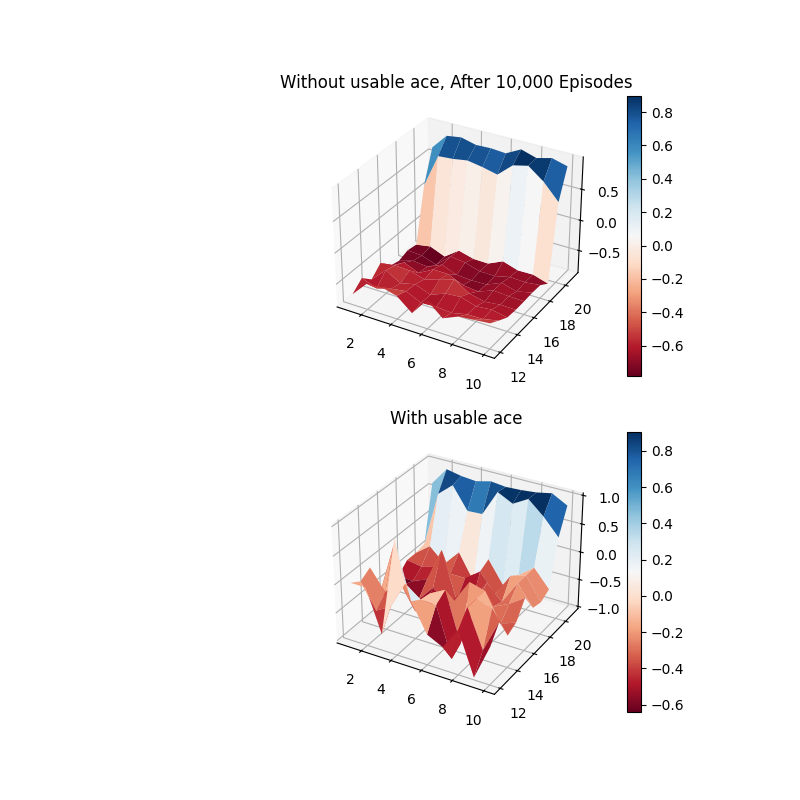

In [9]:
x, y = np.meshgrid(np.arange(1, v_first.shape[1]), np.arange(12, v_first.shape[0]))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(211, projection='3d')
surface = ax.plot_surface(x, y, v_first[12:, 1:, 0], cmap='RdBu');
ax.set_title('Without usable ace, After 10,000 Episodes')
plt.colorbar(surface)

ax = fig.add_subplot(212, projection='3d')
surface = ax.plot_surface(x, y, v_first[12:, 1:, 1], cmap='RdBu');
ax.set_title('With usable ace');
plt.colorbar(surface);

In [10]:
v_second = first_visit_mc(policy, 500_000, True)

Episode  500000 out of  500000

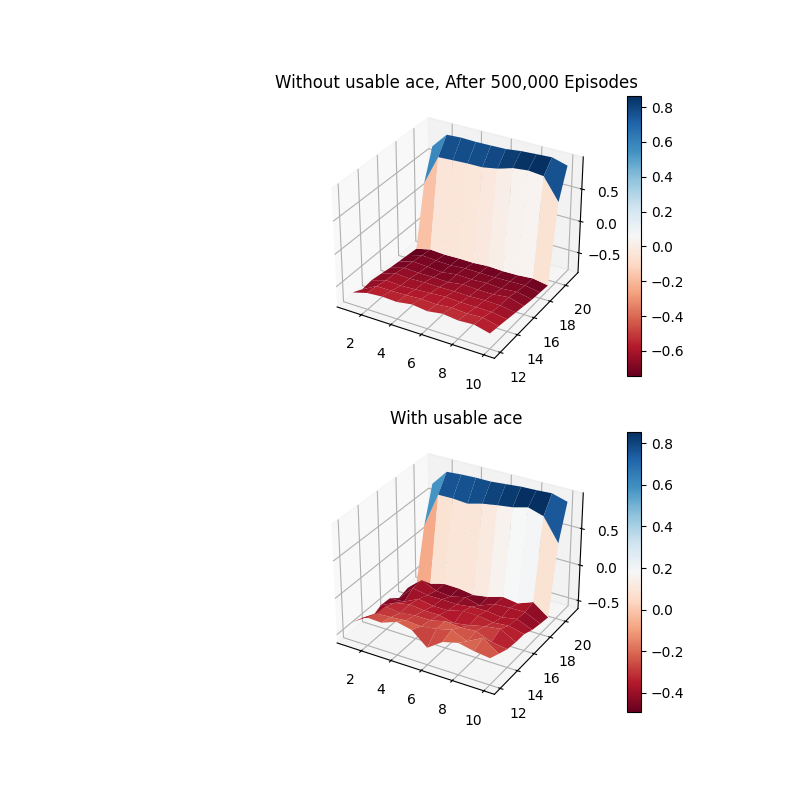

In [11]:
x, y = np.meshgrid(np.arange(1, v_second.shape[1]), np.arange(12, v_second.shape[0]))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(211, projection='3d')
surface = ax.plot_surface(x, y, v_second[12:, 1:, 0], cmap='RdBu');
ax.set_title('Without usable ace, After 500,000 Episodes')
plt.colorbar(surface)

ax = fig.add_subplot(212, projection='3d')
surface = ax.plot_surface(x, y, v_second[12:, 1:, 1], cmap='RdBu');
ax.set_title('With usable ace');
plt.colorbar(surface);